In [1]:
from helper_fun import *

### class developed by me to do basline EDA for raw dataset
from EDA import EDA

In [2]:
df = pd.read_parquet('time_series_dset.pq')
df.head(2)

,item,date,f1,f2,f3
0,1000.84.30,1990-03-01 00:00:01,40.0,1.0,0.0
1,1000.84.23,1990-03-01 00:00:01,1470.0,1.0,0.0


In [3]:
eda_obj =EDA()
eda_obj.fit_transform(df)

Calculating Dataset Statistics
------------------------------------------------------------------------------------

univeriate categorical analysis completed for column: item
univeriate categorical analysis completed for column: date
univeriate numerical analysis completed for column: f1
univeriate numerical analysis completed for column: f2
univeriate numerical analysis completed for column: f3


In [4]:
eda_obj.summary()

Dataset statistics 
 Number of variables:            5 
 Number of observations:         25242100 
 Missing cells:                  0 
 Missing cells (%):              0.0 
 Empty variables count:          0 
 Empty variables/all nulls:      [] 
 ------------------------------------------------------------------------------------
 Variable types 
 Categorical variables:           2 
 Numerical variables:             3 
 Unknown variables:               0 
 ------------------------------------------------------------------------------------

 Univeriate EDA of Numerical Features



,missing_percentage,mean_value,standard_deviation,skew,skewness,kurtosis,kurtosis_R,chi_stat_normality
f1,0.0,901.788112,497600.575364,5024.021367,Left skewed,25241224.087079,"higher kurtosis, heavier tail","[139239128086.99966, 0.0]"
f2,0.0,2.485928,6687.697933,5024.146937,Left skewed,25242065.280902,"higher kurtosis, heavier tail","[1290720723.948574, 0.0]"
f3,0.0,3.381609,993.713736,3783.014805,Left skewed,15186736.499736,"higher kurtosis, heavier tail","[12799187777.278662, 0.0]"


Univeriate EDA of Categorical Features



,missing_percentage,distinct_values,unique_percentage
item,0.0,256.0,0.00
date,0.0,5524594.0,21.89


Bivariate EDA of Categorical Features
 Numerical Features ANOVA Scores

No Target columns Provided

 Categorical Features Chi Square Scores

No Target columns Provided

 Correltion with target

No Target columns Provided


In [5]:
### aggregate(groupby) all the rows with respect to minutes. 
df['date'] = pd.to_datetime(df['date']).dt.strftime("%Y-%m-%d-%H:%M")
df = df.groupby(['item','date']).sum()
df.reset_index(inplace=True)

In [6]:
# df.to_parquet("parsed_df.parquet.gzip")
df.head(3)

,item,date,f1,f2,f3
0,1000.84.0,1990-03-01-01:07,68.0,1.0,0.0
1,1000.84.0,1990-03-01-02:53,40.0,1.0,0.0
2,1000.84.0,1990-03-01-03:19,40.0,1.0,0.0


### There are 256 sku for which we need to generate forecast as per assignment we need to generate forecast for predict only 3 items (1000.84.25,1000.84.23,1000.84.26)

In [7]:
target_df = df[df['item'].isin(['1000.84.25','1000.84.23','1000.84.26'])]

In [8]:
target_df['date'] = pd.to_datetime(target_df['date'],format="%Y-%m-%d-%H:%M")

In [9]:
target_df['date'].dt.day.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 11, 12])

In [10]:
target_df['Year_Months_day'] = target_df['date'].dt.strftime("%Y-%m-%d")

In [11]:
target_df.head(2)

,item,date,f1,f2,f3,Year_Months_day
248420,1000.84.23,1990-03-01 00:00:00,4356.0,10.0,0.0,1990-03-01
248421,1000.84.23,1990-03-01 00:01:00,1108.0,3.0,0.0,1990-03-01


In [12]:
### cleaning the f1 feature first
data = target_df.pivot(index='date', columns='item', values='f1')

In [13]:
date_df = pd.DataFrame(date_range(target_df['date'].min(),target_df['date'].max()),columns=['date'])
date_df.head(2)

,date
0,1990-03-01 00:00:00
1,1990-03-01 00:01:00


In [14]:
date_df = date_df.merge(data.reset_index(),on=['date'],how= 'left')

<AxesSubplot:xlabel='date'>

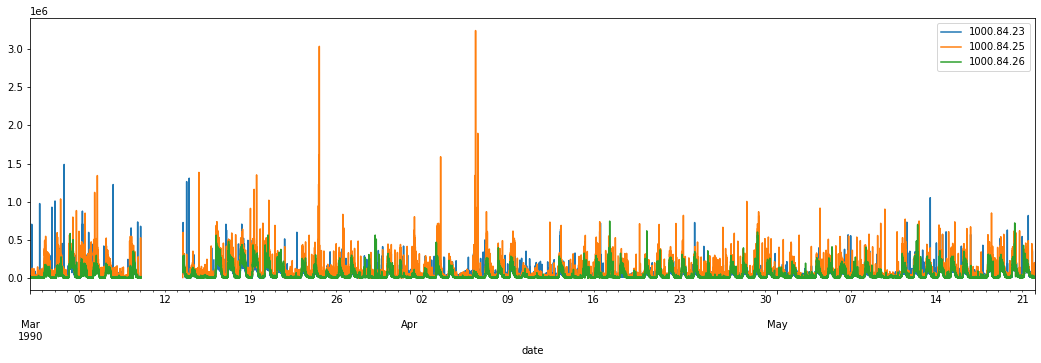

In [15]:
date_df.set_index('date',inplace=True)
date_df.plot(figsize=(18,5))

As per the plot, there are missing values between 1990-03-09 21:17:00,1990-03-13 10:54:00 since it is a large gap we can not use bfill and ffill for such a large gap, we can fill it by interpolation the function but values are changing very frequently here hence taking a chunk of data from previous days and filling the gap

### please review helper function script for fill_data function details

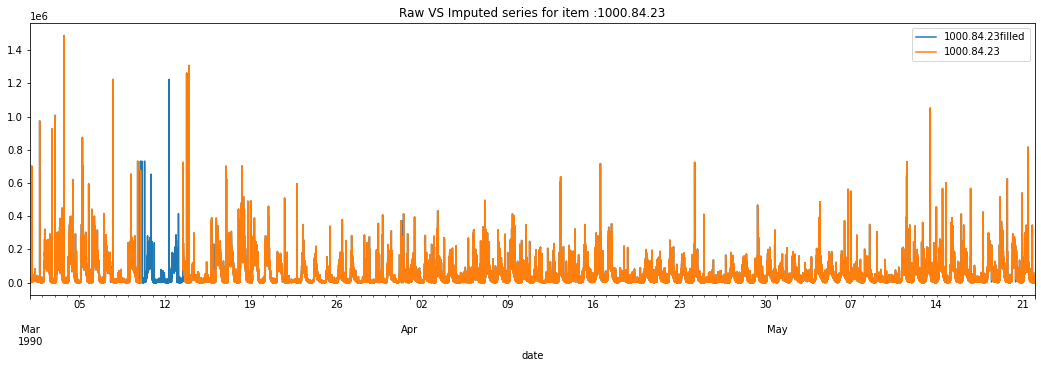

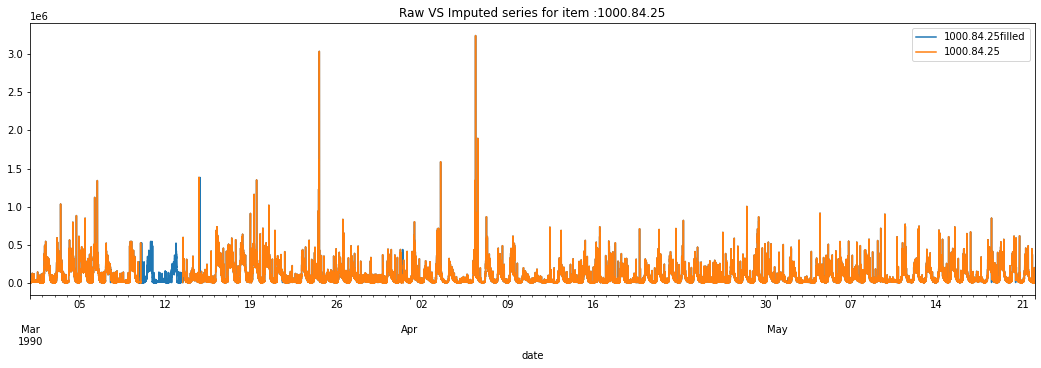

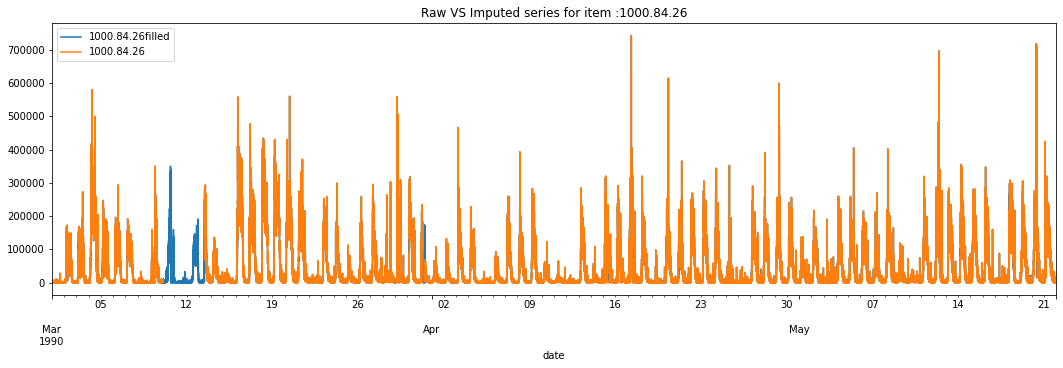

In [16]:
for item in ['1000.84.23','1000.84.25','1000.84.26']:
    date_df[item+'filled'] = fill_data(date_df[item].values)
    date_df[item+'filled'].bfill(inplace=True)## for any remaining missing value
    date_df[[item+'filled',item]].plot(figsize=(18,5),title= f"Raw VS Imputed series for item :{item}")
    plt.show()

In [17]:
### we have some outliers in the data lets clean them up with 3 SD limits

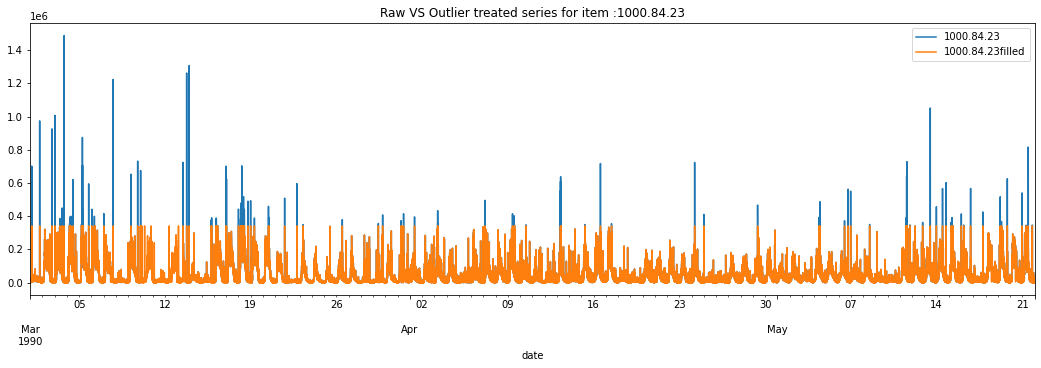

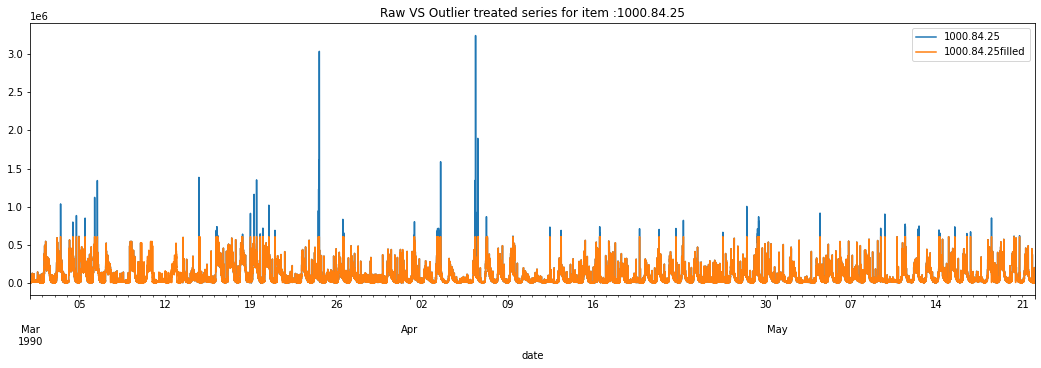

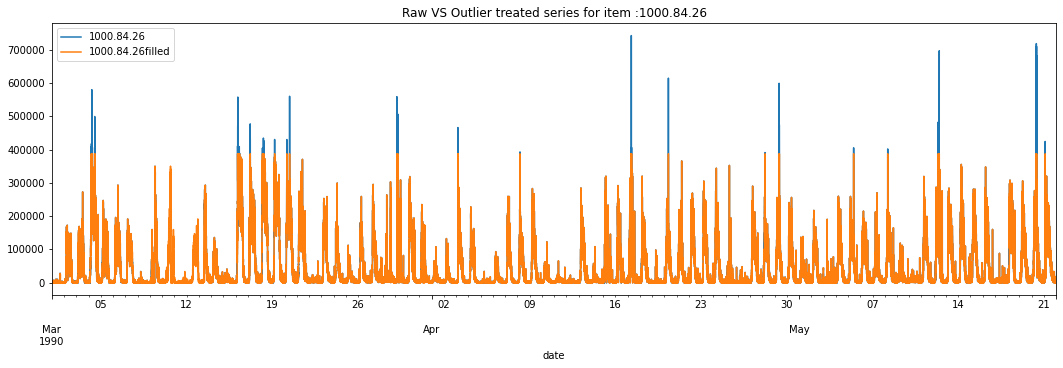

In [18]:
for item in ['1000.84.23','1000.84.25','1000.84.26']:
    date_df[item+'filled'] = stam_outlier(date_df[item+'filled'].values)
    date_df[[item,item+'filled']].plot(figsize=(18,5),title= f"Raw VS Outlier treated series for item :{item}")
    plt.show()

Now as the data is treated completely

<AxesSubplot:xlabel='date'>

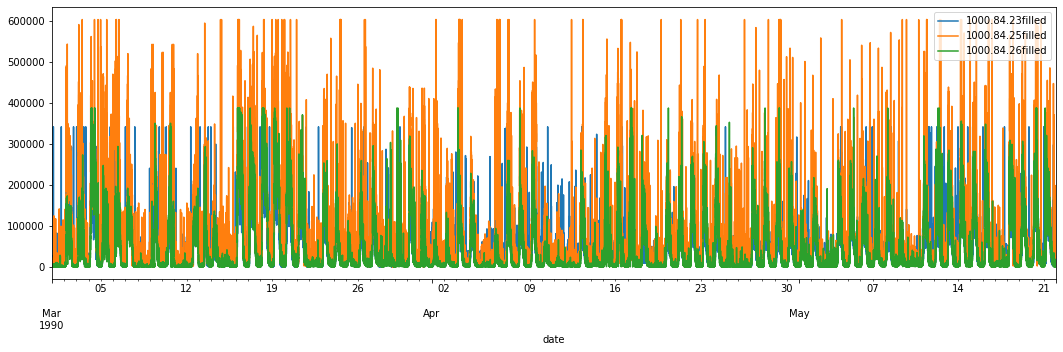

In [19]:
date_df = date_df[[i for i in date_df.columns if 'filled' in i]]
date_df.plot(figsize=(18,5))

In [20]:
## scaling data usng min max scaler
scaler = MinMaxScaler()
scaler.fit(date_df)
sc_df =pd.DataFrame(scaler.transform(date_df),columns=date_df.columns,index= date_df.index)

<AxesSubplot:xlabel='date'>

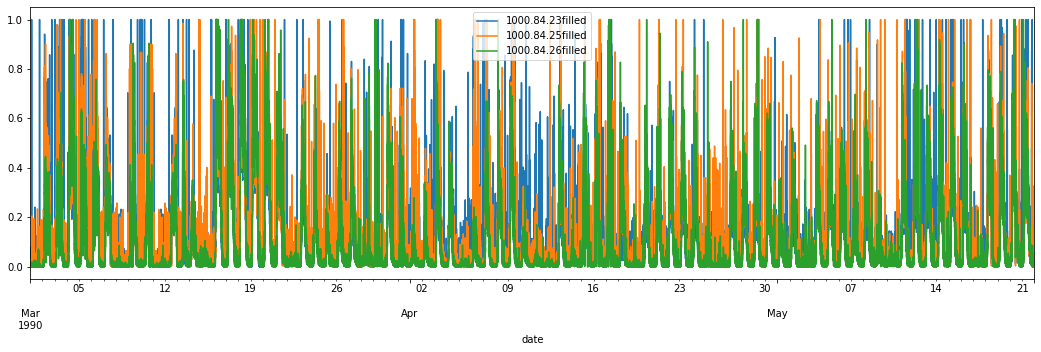

In [21]:
sc_df.plot(figsize=(18,5))

## As we are going to use parametric model checking for stationary

In [22]:
from statsmodels.tsa.stattools import adfuller

In [23]:
for cols in sc_df.columns:
    dftest = adfuller(sc_df[cols].values[:10000], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (cols ,dfoutput['p-value'])

1000.84.23filled 0.004783085334559304
1000.84.25filled 0.002806439323359692
1000.84.26filled 0.029127605136975154


### as p-values are less then 0.05, series are alreay stationary

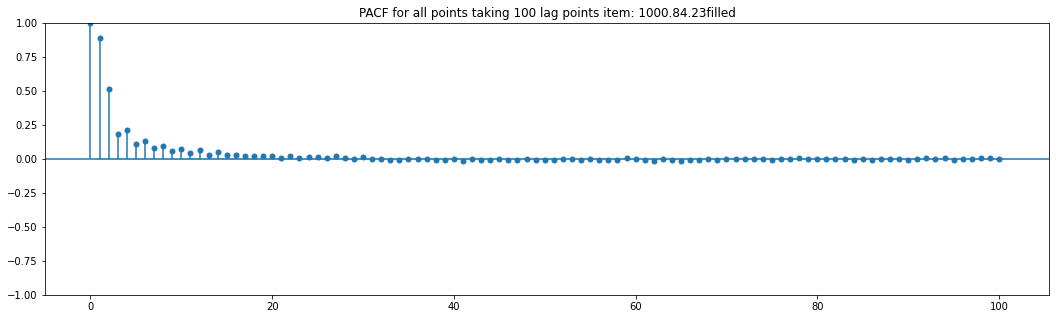

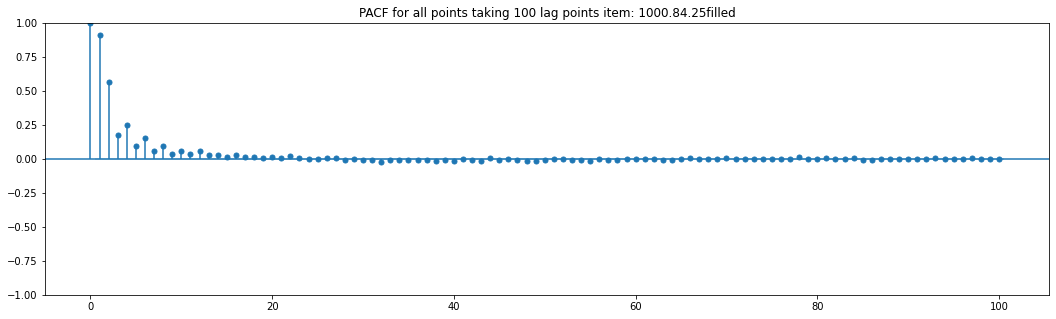

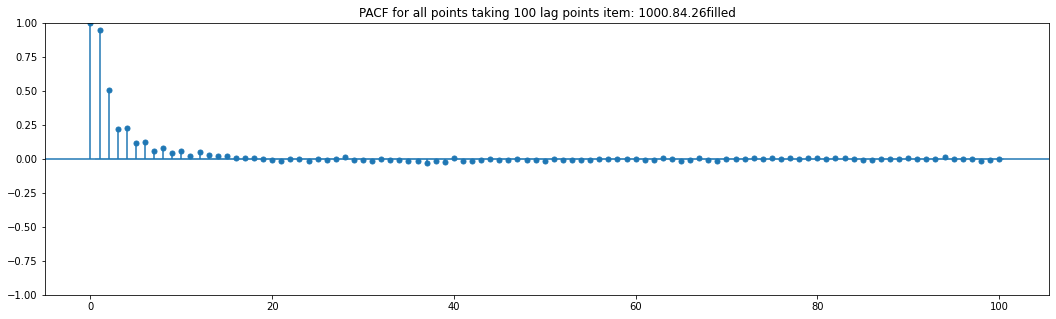

In [24]:
### checking the pacf for autocorrelation lags

from statsmodels.graphics.tsaplots import plot_pacf
for cols in sc_df.columns:
    fig, ax = plt.subplots(figsize=(18,5))
    plot_pacf(sc_df[cols],lags = 100,ax =ax,title=f'PACF for all points taking 100 lag points item: {cols}')
    plt.show()

### confidence intervel is very small hence will will go for first 50 point as steps size, mean's last 50 minuts data can affect the current state of item

In [288]:
n_steps=4000
n_fatures= 1 ### univeriate series
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(16,return_sequences=True,activation='relu',input_shape = (n_steps,n_fatures)))
model.add(tf.keras.layers.LSTM(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

In [289]:
model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_79 (LSTM)               (None, 4000, 16)          1152      
_________________________________________________________________
lstm_80 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 17        
Total params: 3,281
Trainable params: 3,281
Non-trainable params: 0
_________________________________________________________________


In [290]:
### Converting dataset for supervised leanring problem
X,y = split_sequence(sc_df[cols].values, n_steps)
X = X.reshape((X.shape[0], X.shape[1], n_fatures))

In [291]:
from sklearn.model_selection import train_test_split
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=0.40, random_state=42)

In [292]:
### spliting test validation datasets
X_valid, X_test, y_valid, y_test = train_test_split(X_test_valid, y_test_valid, test_size=0.50, random_state=42)

In [293]:
### early stopping on validation loss
# from tf.keras.callbacks.EarlyStopping import ModelCheckpoint, EarlyStopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min')

### train test split for data

In [ ]:
model.fit(X_train, y_train,validation_data=(X_valid, y_valid), epochs=5,callbacks=es)

Epoch 1/5
  96/2139 [>.............................] - ETA: 47:54 - loss: 0.0256 - accuracy: 0.0239

In [176]:
model.save("first_model.h5")

## calculating MAPE for test set

In [231]:
from sklearn.metrics import mean_absolute_percentage_error as MAPE

In [243]:
### Ploting predicted VS actual for test dataset
test_pred = model.predict(X_test)
pred_df =pd.DataFrame([y_test,test_pred.flatten()]).T
pred_df.columns = ['Actual','Prediction']

<AxesSubplot:>

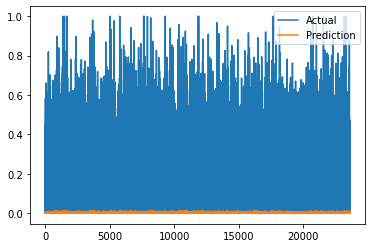

In [244]:
pred_df.plot()

In [ ]:
## Next 30 min forecast by model

In [195]:
last_200_vals= sc_df[cols].tail(200).values
n_steps=100

In [221]:
def forecast_ahead(scr_list,model,steps = 30):
    for i in range(steps):
        pred = model.predict(scr_list[i:-n_steps].reshape(1,n_steps,1))
        scr_list =np.hstack([scr_list,pred[0]])
    return scr_list[i:-steps]

In [222]:
forecast_ahead(last_200_vals,model)

array([2.33404356e-03, 4.16203343e-03, 9.63051160e-03, 8.33181258e-03,
       3.76958363e-03, 3.76958363e-03, 1.31109217e-02, 4.11039530e-03,
       8.02198379e-03, 3.76958363e-03, 7.98325519e-03, 4.33502117e-03,
       0.00000000e+00, 1.51557917e-03, 7.64244352e-03, 4.76361767e-03,
       4.98307973e-03, 4.14912390e-03, 0.00000000e+00, 1.45929361e-02,
       5.35229237e-03, 2.06552528e-04, 1.55947158e-03, 3.10448449e-02,
       8.70618904e-03, 1.78358108e-02, 1.20626676e-02, 1.15153034e-02,
       1.15411225e-02, 5.31098187e-03, 9.63051160e-04, 3.99679141e-03,
       3.95806281e-03, 5.67244879e-03, 0.00000000e+00, 1.17993131e-02,
       5.57691824e-04, 5.57691824e-04, 1.70431654e-02, 3.87285989e-03,
       4.15686962e-04, 7.64244352e-03, 7.83866842e-03, 3.18090892e-03,
       1.11564184e-02, 6.32308925e-03, 1.03276264e-04, 6.28952446e-03,
       1.56205349e-03, 4.11814102e-03, 3.61466923e-04, 6.18624820e-03,
       0.00000000e+00, 1.34259143e-04, 9.26646277e-03, 1.14068633e-02,
      

In [223]:
sc_df[cols]

date
1990-03-01 00:00:00    0.003770
1990-03-01 00:01:00    0.003770
1990-03-01 00:02:00    0.003770
1990-03-01 00:03:00    0.003770
1990-03-01 00:04:00    0.003770
                         ...   
1990-05-21 23:55:00    0.003770
1990-05-21 23:56:00    0.000168
1990-05-21 23:57:00    0.005569
1990-05-21 23:58:00    0.002688
1990-05-21 23:59:00    0.009540
Name: 1000.84.26filled, Length: 118080, dtype: float64